<a href="https://colab.research.google.com/github/kwang2424/anime_collab/blob/main/Anime_Collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,}'.format

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *

In [ ]:
ratings = pd.read_csv('ratings.csv', nrows=2500000)
ratings.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [ ]:
animes = pd.read_csv('anime.csv')
animes.rename(columns={"MAL_ID": "anime_id"}, inplace=True)
animes = animes[animes.Type == 'TV']
print(animes['anime_id'].unique())
animes.head()

[    1     6     7 ... 48488 48491 48492]


,anime_id,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entertainment","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,33719,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",Unknown,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0
5,15,Eyeshield 21,7.95,"Action, Sports, Comedy, Shounen",Unknown,アイシールド21,TV,145,"Apr 6, 2005 to Mar 19, 2008",Spring 2005,"TV Tokyo, Nihon Ad Systems, TV Tokyo Music, Shueisha","VIZ Media, Sentai Filmworks",Gallop,Manga,23 min. per ep.,PG-13 - Teens 13 or older,604.0,1003,148259,2066,13907,78349,14228,11573,30202,9226.0,14904.0,22811.0,16734.0,6206.0,2621.0,795.0,336.0,140.0,151.0


In [ ]:
unique_ids = animes['anime_id'].unique()
print('before', ratings.shape)
filtered_ratings = ratings[ratings['anime_id'].isin(unique_ids)]
print('after', filtered_ratings.shape)
filtered_ratings.head()

before (2500000, 3)
after (1673770, 3)


,user_id,anime_id,rating
2,0,3010,7
4,0,2762,9
8,0,1571,10
9,0,121,9
10,0,356,9


In [ ]:
ratings = ratings.merge(animes)

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='Name', bs=64)
dls.show_batch()

,user_id,Name,rating
0,12414,Ookami to Koushinryou,10
1,6354,Koutetsujou no Kabaneri,10
2,13138,Shijou Saikyou no Deshi Kenichi,7
3,12308,Mouryou no Hako,8
4,10993,Seikai no Senki II,9
5,1393,Owarimonogatari,8
6,2111,Bakuman.,9
7,13602,School Days,6
8,4949,Zetsuen no Tempest,10
9,3467,Angel Beats!,10


In [ ]:
class AnimeCF(Module):
  def __init__(self, n_users, n_animes, n_factors, y_range=(0,10.25)):
    self.user_factors = Embedding(n_users, n_factors)
    self.anime_factors = Embedding(n_animes, n_factors)
    self.user_bias = Embedding(n_users, 1)
    self.anime_bias = Embedding(n_animes, 1)
    self.y_range = y_range

  def forward(self, x):
    self.users = self.user_factors(x[:, 0])
    self.animes = self.anime_factors(x[:, 1])
    res = (self.users * self.animes).sum(dim=1, keepdim=True)
    res += self.user_bias(x[:, 0]) + self.anime_bias(x[:, 1])
    return sigmoid_range(res, *self.y_range, )

In [ ]:
n_users  = len(dls.classes['user_id'])
n_animes = len(dls.classes['Name'])

In [ ]:
model = AnimeCF(n_users, n_animes, 150)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(10, 1e-2, wd=0.1)

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

In [ ]:
learn = collab_learner(dls, n_factors=75, y_range=(0, 10.5))
learn.fit_one_cycle(10, 5e-3, wd=0.001)

epoch,train_loss,valid_loss,time
0,1.623082,1.593442,03:08
1,1.498935,1.846358,03:08
2,1.555896,2.057219,03:14
3,1.520247,2.036202,03:17
4,1.346224,1.936849,03:10
5,1.083497,1.815257,03:15
6,0.849011,1.723008,03:12
7,0.679636,1.669016,03:08
8,0.561437,1.646591,03:15
9,0.582565,1.641481,03:12


In [ ]:
learn.fit_one_cycle(10, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time
0,0.639887,1.618275,03:15
1,1.161638,1.734209,03:08
2,1.433800,1.771127,03:03
3,1.314412,1.732553,03:03
4,1.168302,1.654091,03:03
5,0.986833,1.571904,03:02
6,0.869853,1.491683,03:01
7,0.731439,1.452490,03:03
8,0.664001,1.432861,03:03
9,0.652565,1.426811,03:02


In [ ]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(13288, 75)
  (i_weight): Embedding(3955, 75)
  (u_bias): Embedding(13288, 1)
  (i_bias): Embedding(3955, 1)
)

In [ ]:
b_w = learn.model.i_bias.weight
anime_bias = b_w.squeeze()
idxs = -anime_bias.argsort()[:20]
[dls.classes['Name'][i] for i in idxs]

['Hakumei to Mikochi',
 'Beck',
 'Sakurako-san no Ashimoto ni wa Shitai ga Umatteiru',
 'Himouto! Umaru-chan',
 'Haikara-san ga Tooru',
 'Yume de Aetara (TV)',
 'Gokinjo Monogatari',
 'DRAMAtical Murder',
 'Kono Subarashii Sekai ni Shukufuku wo! 2',
 "Dog Days''",
 'Yume wo Kanaeru Zou',
 'Jigoku Sensei Nube',
 'Steins;Gate',
 'Duel Masters Victory',
 'Gakuen Senki Muryou',
 'Star☆Twinkle Precure',
 'Busou Renkin',
 'Kyattou Ninden Teyandee',
 'Magi: Sinbad no Bouken (TV)',
 'Ushio to Tora (TV)']

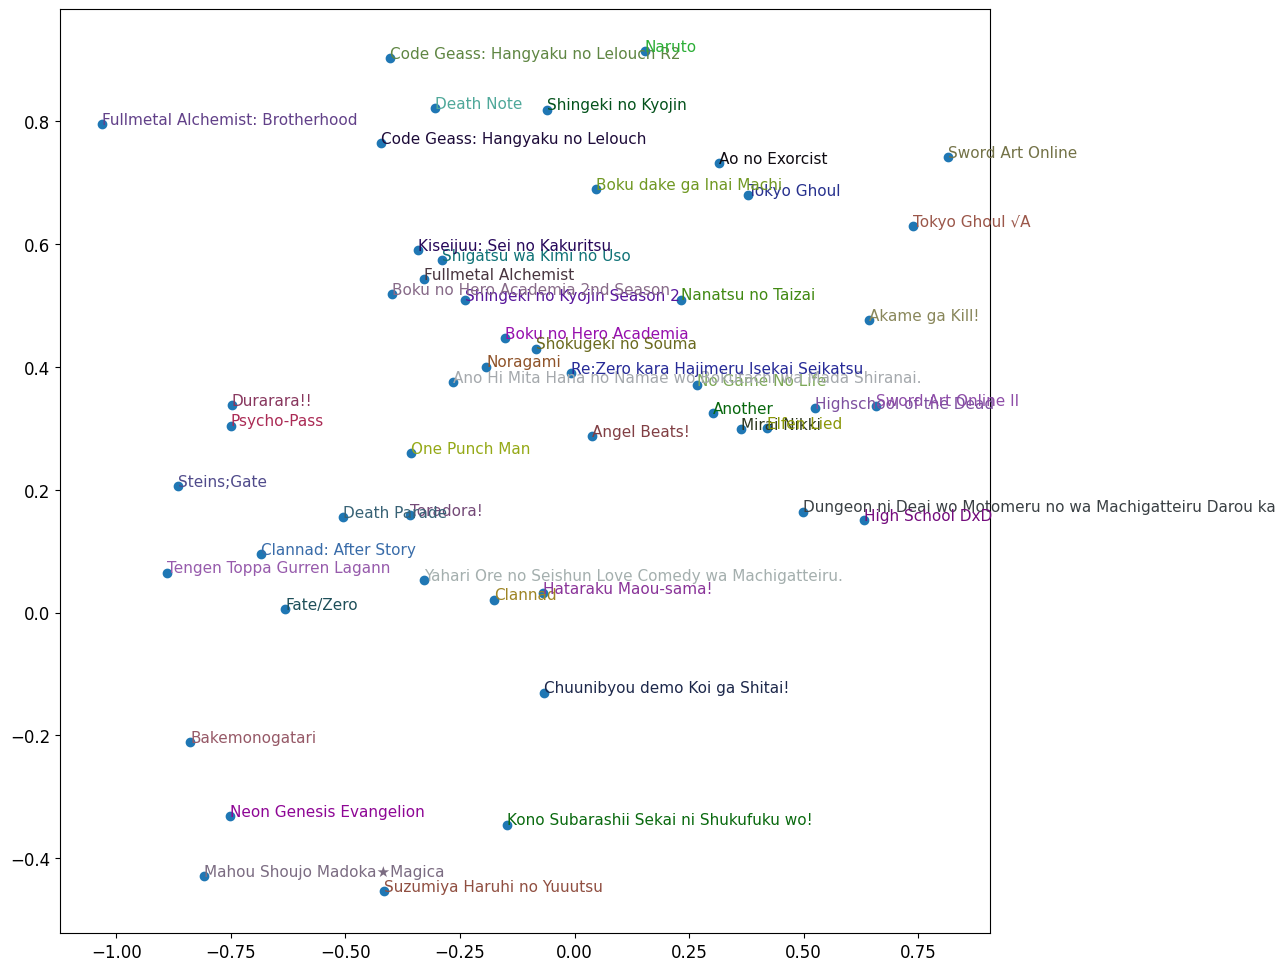

In [ ]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('Name')['rating'].count()
top_animes = g.sort_values(ascending=False).index.values[:2000]
top_idxs = tensor([learn.dls.classes['Name'].o2i[a] for a in top_animes])
anime_w = learn.model.i_weight.weight[top_idxs].cpu().detach()
anime_pca = anime_w.pca(3)
fac0,fac1,fac2 = anime_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_animes[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()